In [1]:
# load training data
from util.createUnlabeledTrainingData import generate_training_data
import glob

strokes_dir = "../lineStrokes-all/lineStrokes"
file_list = glob.glob(strokes_dir + "/**/*.xml", recursive=True)
file_list = file_list[:1000] # limit to 1000 files for testing
training_data = generate_training_data(file_list)
print(training_data[0])

Processing XML files: 100%|██████████| 1000/1000 [00:05<00:00, 194.28it/s]


tensor([[ 0.0000,  0.0000,  0.0000,  1.0000],
        [-0.0137,  0.3699,  0.0000,  1.0000],
        [-0.0822,  0.4384,  0.0000,  1.0000],
        ...,
        [ 0.1233,  0.2329,  0.0000,  1.0000],
        [-0.0685,  0.0274,  0.0000,  1.0000],
        [ 0.0411,  0.0548,  0.0000,  1.0000]])


In [87]:
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
from math import sqrt

class UnlabelledLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, num_layers=2, num_mixtures=2):
        super(UnlabelledLSTM, self).__init__()
        self.num_mixtures = num_mixtures

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_mixtures*5)

    def forward(self, x, hidden=None):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        out = out.view(out.size(0), out.size(1), self.num_mixtures, 5)

        pi = out[..., 0]
        mu = out[..., 1:3]
        sigma = out[..., 3:5]
        pi = F.softmax(pi, dim=-1)
        sigma = torch.exp(sigma)
        return pi, mu, sigma, hidden

        # x, hidden = self.lstm(x)
        # x = self.fc(x)
        # # first two outputs are between -1 and 1, so apply tanh
        # x[:, :2, :] = torch.tanh(x[:, :2, :])
        # # apply softmax to last two outputs
        # x[:, -2:, :] = torch.softmax(x[:, -2:, :], dim=-1)
        # return x, hidden

def mdn_loss(pi, mu, sigma, target):
    # target: (batch, seq_len, 2)
    # Compute the probability for each mixture component
    # First, expand target to (batch, seq_len, num_mixtures, 2)
    target = target.unsqueeze(2).expand_as(mu)
    # Compute the Gaussian probability density for each dimension independently
    norm = 1.0 / (sqrt(2 * torch.pi) * sigma)
    exp_term = torch.exp(-0.5 * ((target - mu) / sigma)**2)
    prob = norm * exp_term  # (batch, seq_len, num_mixtures, 2)
    # Assuming independence between dx and dy, multiply probabilities for both dimensions
    prob = prob[..., 0] * prob[..., 1]  # (batch, seq_len, num_mixtures)
    # Weight by mixing coefficients and sum over mixtures
    prob = pi * prob
    prob = torch.sum(prob, dim=-1)  # (batch, seq_len)
    # Negative log likelihood
    nll = -torch.log(prob + 1e-8)  # avoid log(0)
    return torch.mean(nll)

In [108]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import ipywidgets as widgets

def sample_from_mdn(pi, mu, sigma):
    """
    Given mixture parameters from one time step:
      - pi: shape (num_mixtures,)
      - mu: shape (num_mixtures, 2) for dx and dy
      - sigma: shape (num_mixtures, 2) for dx and dy
    Sample a mixture component according to pi and then draw a sample from its Gaussian.
    Returns: (dx, dy) as a 2-element tensor.
    """
    # Sample one mixture index according to the probabilities in pi.
    # Make sure pi is a proper probability vector (it should be after softmax).
    mixture_idx = torch.multinomial(pi, num_samples=1).item()
    # Sample from the corresponding Gaussian for dx and dy.
    # Here we assume dx and dy are independent.
    sample = mu[mixture_idx] + sigma[mixture_idx] * torch.randn(2)
    return sample  # tensor of shape (2,)

def generate_sequence(model_d, length=100):
    """
    Uses the MDN model to generate a new sequence of stroke commands.
    The model outputs MDN parameters (pi, mu, sigma) for dx and dy.
    For simplicity, we assume the pen is always "down" (pen state = [0, 1]).
    
    Returns a tensor of shape (length, 4), where each row is [dx, dy, 0, 1].
    """
    # copy model and put it on the cpu
    model = UnlabelledLSTM()
    model.load_state_dict(model_d.state_dict())
    model.to('cpu')
    model.eval()
    # Start with an initial input vector.
    # You might choose a different starting point depending on your training.
    input_seq = torch.zeros(1, 1, 4)  # (batch=1, seq_len=1, feature_dim=4)
    hidden = None  # carry over the hidden state for generation
    output_seq = []

    with torch.no_grad():
        for _ in range(length):
            # Get the MDN outputs; note that our model returns (pi, mu, sigma, hidden)
            pi, mu, sigma, hidden = model(input_seq, hidden)
            pi = pi
            mu = mu
            sigma = sigma

            # For our 1-step input, pick the outputs for the current (and only) time step.
            # Each of these has shape: 
            #   pi: (1, 1, num_mixtures)
            #   mu: (1, 1, num_mixtures, 2)
            #   sigma: (1, 1, num_mixtures, 2)
            pi_t = pi[0, -1]       # shape: (num_mixtures,)
            mu_t = mu[0, -1]       # shape: (num_mixtures, 2)
            sigma_t = sigma[0, -1] # shape: (num_mixtures, 2)
            
            # Sample a dx, dy from the MDN distribution.
            sample = sample_from_mdn(pi_t, mu_t, sigma_t)  # (2,)
            dx, dy = sample[0].item(), sample[1].item()
            
            # Determine pen state.
            # In the original code you compared two outputs to decide pen up/down.
            # Here, since our model only predicts dx and dy, we'll assume the pen is down.
            # (If you later extend your model to predict pen state, update this accordingly.)
            pen_state = [0, 1]  # [pen up, pen down]
            
            # Form the next output vector.
            next_output = torch.tensor([dx, dy, pen_state[0], pen_state[1]], dtype=torch.float32)
            output_seq.append(next_output.unsqueeze(0))  # shape (1, 4)
            
            # Feed this as the next input. It must have shape (1, 1, 4).
            input_seq = next_output.unsqueeze(0).unsqueeze(0)
        
    # Stack the outputs into a sequence: shape (length, 4)
    return torch.cat(output_seq, dim=0)

def convert_to_global_coords(seq, starting_point=(0.0, 0.0)):
    """
    Converts a sequence of relative stroke commands (dx, dy, _, _)
    to a sequence of global coordinates (x, y).
    Assumes the starting point is (0, 0).
    """
    global_seq = []
    prev_x, prev_y = starting_point
    # Loop through each step; seq is expected to be a tensor of shape (length, 4)
    for step in seq:
        # Here we ignore the pen state values (last two entries).
        dx, dy = step[0].item(), step[1].item()
        x = prev_x + dx
        y = prev_y + dy
        global_seq.append((x, y))
        prev_x, prev_y = x, y
    return global_seq

# takes a given model and length and generates a sequence and shows it all in one go
def plot_model(model, length=100, device='cpu'):
    generated_seq = generate_sequence(model, length=length)
    global_seq = convert_to_global_coords(generated_seq)
    fig, ax = plt.subplots()
    ax.plot([x for x, _ in global_seq], [y for _, y in global_seq])
    ax.set_aspect("equal")
    ax.axis("off")


In [ ]:
# Training!
use_modelfile = True
model_filepath = "../models/model_unlabeled.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

if use_modelfile:
    model = UnlabelledLSTM().to(device)
    model.load_state_dict(torch.load(model_filepath, weights_only=True))
else:
    model = UnlabelledLSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000


for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    for seq in training_data:
        # skip too short sequences
        if seq.size(0) < 2:
            continue

        input_seq = seq[:-1].unsqueeze(0).to(device)
        target_seq = seq[1:, :2].unsqueeze(0).to(device)

        optimizer.zero_grad()
        pi, mu, sigma, _ = model(input_seq)
        loss = mdn_loss(pi, mu, sigma, target_seq)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), model_filepath)
        plot_model(model)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(training_data)}")

using device: cuda
Epoch 1/10000, Loss: -3.495473144888878
Epoch 2/10000, Loss: -3.5140002992153168
Epoch 3/10000, Loss: -3.5353008897304536
Epoch 4/10000, Loss: -3.400041167140007
Epoch 5/10000, Loss: -3.539537670493126
Epoch 6/10000, Loss: -3.5627876272201537
Epoch 7/10000, Loss: -3.5200030744075774
Epoch 8/10000, Loss: -3.5729335250854493
Epoch 9/10000, Loss: -3.5825217995643617
Epoch 10/10000, Loss: -3.5751333951950075
Epoch 11/10000, Loss: -3.508211531996727
Epoch 12/10000, Loss: -3.587573706626892


(-0.4296014927538636,
 3.1155403618475246,
 -0.5735015709651634,
 4.539168343297206)

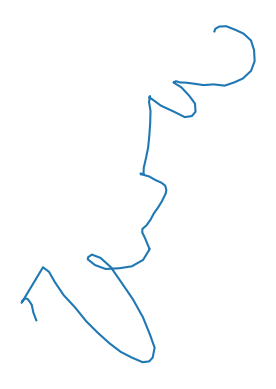

In [44]:
plot_model(model.to('cpu'))